In [317]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas
import numpy as np
import os
import moviepy.video.io.ImageSequenceClip
from moviepy.editor import AudioFileClip
from shapely.geometry import box


# we're going to plot nyc historical shooting data by minute.
# color each hour uniquely

plot_dir = "../Plots/NYC_shootings/"
data_dir = "../Data/"

# if folder does not exist, create it
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# delete existing files
for f in os.listdir(plot_dir):
    os.remove(os.path.join(plot_dir, f))

In [318]:
# load nyc geopandas file https://github.com/fillerwriter/nyc-streets
basemap = geopandas.read_file(data_dir+"nyc-streets.geojson")

# set coordinates
basemap = basemap.to_crs(epsg=4326)

# load shootings data from NYPD
shootings = pd.read_csv(data_dir+"NYPD_Shooting_Incident_Data__Historic_.csv")

In [319]:
# clean shootings
shootings = shootings[['OCCUR_DATE', 'OCCUR_TIME', 'Latitude', 'Longitude']]

# drop seconds from time e.g. 6:39:00 PM -> 6:39 PM
shootings['OCCUR_TIME'].str.split(':').str[0] + ':' + shootings['OCCUR_TIME'].str.split(':').str[1]

# get hour of day
shootings['hour'] = shootings['OCCUR_TIME'].str.split(':').str[0].astype(int)

# get minute of day
shootings['minute'] = shootings['OCCUR_TIME'].str.split(':').str[1].astype(int)

# get year
shootings['year'] = shootings['OCCUR_DATE'].str.split('/').str[2].astype(int)

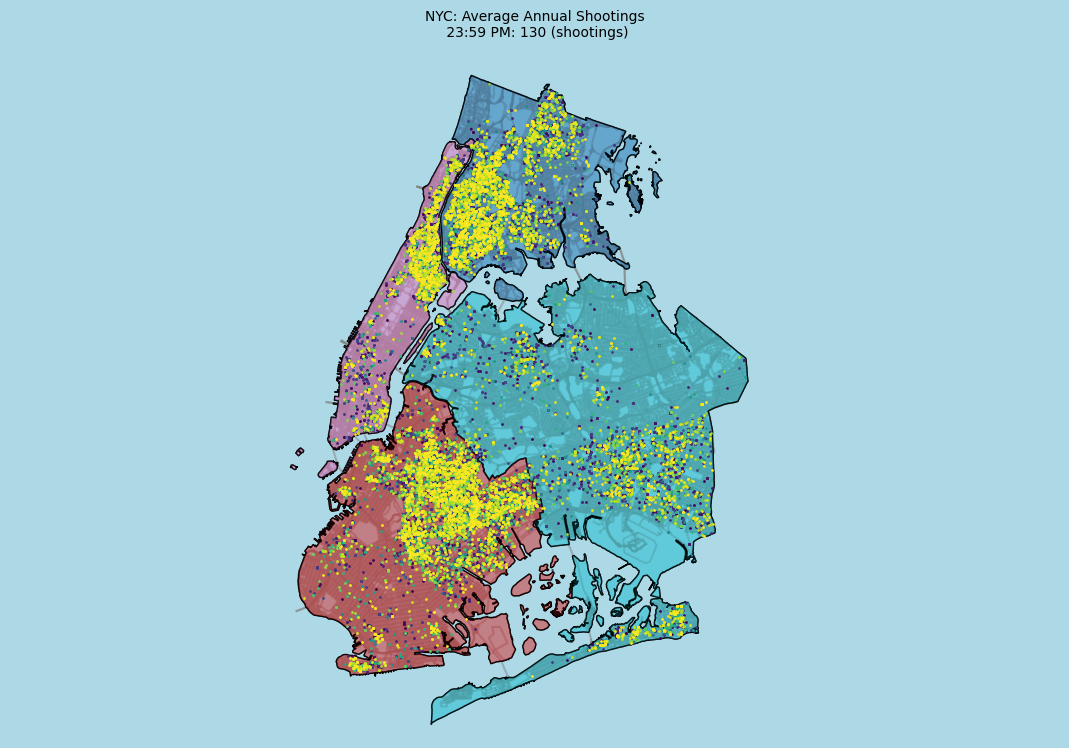

In [320]:
# Creating axes and plotting world map
fig = plt.figure(figsize=(16,9)) 

# Create axes
ax = fig.add_subplot(111)

ax.set_axis_off()

map = basemap.plot(color="grey",ax=ax, alpha=0.5, zorder=0)
# get map limits 
x0, x1, y0, y1 = map.axis()

ax.set_xlim([x0-.2,x1+.22])
ax.set_ylim([y0,y1])

# get aspect ratio
x0, x1, y0, y1 = map.axis()

# lets us nybb
nybb = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# adjust nybb to fit plots coordinates
nybb = nybb.to_crs(epsg=4326)

# subset nybb to only include all boroughs except staten island
nybb_subsetted = nybb[nybb['BoroName'] != 'Staten Island']

# set boundary color to black
nybb_subsetted.boundary.plot(ax=ax, linewidth=1, color='black', zorder=1)

# use cmap for colors on bourough name
nybb_subsetted.plot(ax=ax, linewidth=1, zorder=2,alpha=.5, edgecolor='black', column='BoroName', legend=False)

# subset shootings to be in nybb_subsetted
shootings_subset = shootings[(shootings['Latitude'] > nybb_subsetted.total_bounds[1]) & (shootings['Latitude'] < nybb_subsetted.total_bounds[3]) & (shootings['Longitude'] > nybb_subsetted.total_bounds[0]) & (shootings['Longitude'] < nybb_subsetted.total_bounds[2])]
# set background color to lightgrey
fig.patch.set_facecolor('lightblue')

frames = shootings.hour.nunique()

# # create a list of colors of size frames
colors = plt.cm.viridis(np.linspace(0, 1, frames))

# skipping for now
# we need to reorder colors as night is typically 0-8am, and 8-12pm, day is 8am-8pm
night_indices = np.concatenate([np.arange(0,8), np.arange(20,24)])
day_indices = np.arange(8,20)


for i in range(24):
    # get mean shooting per year by hour
    avg_shootings = round(shootings_subset[shootings_subset['hour']==i].groupby('year').size().mean())
    for j in range(60):
        # plot shootings by hour
        shootings_subset[(shootings_subset['hour']==i) & (shootings_subset['minute']==j)].plot(x='Longitude', y='Latitude', kind='scatter',color =  colors[i],s=1, ax=ax, zorder=3)
        AM_PM = 'AM' if i < 12 else 'PM'
        # add 0 to single digit minutes
        j = f'0{j}' if j < 10 else j
        plt.title(f'NYC: Average Annual Shootings\n {i}:{j} {AM_PM}: {avg_shootings} (shootings)', fontsize=10)
        # 200 is good dpi, but for fast lets do 40
        plt.savefig(f'{plot_dir}{i}_{j}.jpg', bbox_inches='tight', pad_inches=0, dpi=200) 


In [323]:
# frames per second
fps=24

image_files = [os.path.join(plot_dir,img)
               for img in os.listdir(plot_dir)
               if img.endswith(".jpg")]

# sort images by number
image_files = sorted(image_files, key=lambda x: int(x.split('/')[-1].split('.')[0]))

# we then want to add about 5 seconds of the last frame
for i in range(5*fps):
    image_files.append(image_files[-1])


clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)

# resize to 1080p
clip_resized = clip.resize( (1920,1080) )

# add audio
audioclip = AudioFileClip("../Assets/Trio for Piano Violin and Viola.mp3")
clip_resized.audio = audioclip.set_duration(clip_resized.duration)

clip_resized.write_videofile('../Videos/nyc_shootings.mp4')

                                                                        
                                                                        
chunk:  94%|█████████▍| 1351/1434 [1:20:03<00:00, 1733.48it/s, now=None]

Moviepy - Building video ../Videos/nyc_shootings.mp4.
MoviePy - Writing audio in nyc_shootingsTEMP_MPY_wvf_snd.mp3













                                                                        
                                                                        
chunk:  94%|█████████▍| 1351/1434 [1:20:04<00:00, 1733.48it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ../Videos/nyc_shootings.mp4












































































































































































































































































































































































































































































































                                                                        
chunk:  94%|█████████▍| 1351/1434 [1:21:04<00:00, 1733.48it/s, now=None]

Moviepy - Done !


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'nyc_shootingsTEMP_MPY_wvf_snd.mp3'